### Compare Blondin Toy Models ###

In [26]:
import pandas as pd
import re
from tardis.util.base import parse_quantity
import numpy as np
import yaml
from tardis import run_tardis
from astropy import units as u
import base64
from IPython.display import HTML



In [27]:

def create_df_download_link( df, title="Download CSV file", filename="data.csv", type='zip'):
    if type != 'zip':
        csv = df.to_csv()
        b64 = base64.b64encode(csv.encode())
        payload = b64.decode()
    else:
        payload = df.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

def create_download_link(download_data, title="Download CSV file", filename="data.csv", type='zip'):
    if type != 'zip':
        csv = df.to_csv()
        b64 = base64.b64encode(csv.encode())
        payload = b64.decode()
    else:
        payload = df.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

pattern_remove_bracket = re.compile('\[.+\]')
t0_pattern = re.compile('tend = (.+)\n')


def read_blondin_toymodel(fname):
    with open(fname, 'r') as fh:
        for line in fh:
            if line.startswith("#idx"):
                break
        else:
            raise ValueError('File {0} does not conform to Toy Model format as it does not contain #idx')
    columns = [pattern_remove_bracket.sub('', item) for item in line[1:].split()]
    
    raw_blondin_csv =  pd.read_csv(fname, delim_whitespace=True, comment='#', header=None, names=columns)
    raw_blondin_csv.set_index('idx', inplace=True)
    
    blondin_csv = raw_blondin_csv.loc[:, ['vel', 'dens', 'temp', 'X_56Ni0', 'X_Ti', 'X_Ca', 'X_S', 'X_Si', 'X_O', 'X_C']]
    rename_col_dict = {'vel':'velocity', 'dens':'density', 'temp':'t_electron'}
    rename_col_dict.update({item:item[2:] for item in blondin_csv.columns[3:]})
    rename_col_dict['X_56Ni0'] = 'Ni56'
    blondin_csv.rename(columns=rename_col_dict, inplace=True)
    blondin_csv.iloc[:, 3:] = blondin_csv.iloc[:,3:].divide(blondin_csv.iloc[:,3:].sum(axis=1), axis=0)
    
    
    #changing velocities to outer boundary
    new_velocities = 0.5 * (blondin_csv.velocity.iloc[:-1].values + blondin_csv.velocity.iloc[1:].values)
    new_velocities = np.hstack((new_velocities, [2 * new_velocities[-1] - new_velocities[-2]]))
    blondin_csv['velocity'] = new_velocities
    
    
    
    with open(fname, 'r') as fh:
        t0_string = t0_pattern.findall(fh.read())[0]
        
    t0 = parse_quantity(t0_string.replace('DAYS', 'day'))
    blondin_dict = {}
    blondin_dict['model_density_time_0'] = str(t0)
    blondin_dict['description'] = 'Converted {0} to csvy format'.format(fname)
    blondin_dict['tardis_model_config_version'] = 'v1.0'
    blondin_dict_fields = [dict(name='velocity', unit='km/s', desc='velocities of shell outer bounderies.')]
    blondin_dict_fields.append(dict(name='density', unit='g/cm^3', desc='mean density of shell.'))
    blondin_dict_fields.append(dict(name='t_electron', unit='K', desc='electron temperature.'))
    
    for abund in blondin_csv.columns[3:]:
        blondin_dict_fields.append(dict(name=abund, desc='Fraction {0} abundance'.format(abund)))
    blondin_dict['datatype'] = {'fields':blondin_dict_fields}
    
    return blondin_dict, blondin_csv

In [3]:
blondin_dict, blondin_csv = read_blondin_toymodel('snia_toy01.dat')

In [4]:
blondin_dict['v_inner_boundary'] = '9000 km/s'
blondin_dict['v_outer_boundary'] = '20000 km/s'



In [5]:
csvy_file = '---\n{0}\n---\n{1}'.format(yaml.dump(blondin_dict, default_flow_style=False), blondin_csv.to_csv(index=False))

In [12]:
str(u.Quantity(5 * u.cm/u.s, u.km / u.s))

'5e-05 km / s'

In [6]:
with open('blondin_compare.csvy', 'w') as fh:
    fh.write(csvy_file)

**Download the model and setup**

[blondin_compare.csvy](blondin_compare.csvy)

[blondin_model_compare.yml](blondin_model_compare.yml)


In [ ]:
## Download the model 

In [7]:
sim = run_tardis('blondin_model_compare.yml')

[py.warnings         ][WARNING]  /Users/wkerzend/miniconda/envs/tardis3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
 (warnings.py:99)
[py.warnings         ][WARNING]  /Users/wkerzend/miniconda/envs/tardis3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)
 (warnings.py:99)
[py.warnings         ][WARNING]  /Users/wkerzend/miniconda/envs/tardis3/lib/python3.6/site-packages/astropy/units/quantity.py:1067: AstropyDeprecationWarning: The truth value of a Quantity is ambiguous. In the future this will raise a ValueError.
  AstropyDeprecationWarning)
 (warnings.py:99)
[tardis.plasma.standard_plasmas][INFO   ]  Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:74)
[tardis.io.atom_data.util][INFO   ]  Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path. Exists in TARDIS Data repo /Users/wkerzend/projects/tardis/tardis-data/

[tardis.simulation.base][INFO   ]  t_inner 13000.000 K -- next t_inner 13000.000 K (base.py:350)
[tardis.simulation.base][INFO   ]  Starting iteration 3/30 (base.py:266)
[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.23675e+43 erg / s Luminosity absorbed = 8.01326e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:357)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      13117.652070  13122.102732  0.613290  0.641024
	5      13128.710972  13164.042522  0.520966  0.543481
	10     13087.946452  13113.990367  0.469492  0.494977
	15     13117.221906  13173.538351  0.416974  0.432339
	20     13114.807782  13144.097172  0.377475  0.392818
	25     13096.095422  13164.934622  0.347216  0.356523
	30     13094.720257  13184.070310  0.315541  0.319199
	35     13060.231563  13136.832241  0.292868  0.297554
	40     13059.642743  13136.025386  0.267728  0

[tardis.simulation.base][INFO   ]  t_inner 13000.000 K -- next t_inner 13000.000 K (base.py:350)
[tardis.simulation.base][INFO   ]  Starting iteration 6/30 (base.py:266)
[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.22714e+43 erg / s Luminosity absorbed = 8.09114e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:357)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      13133.133359  13196.025024  0.661105  0.650910
	5      13180.154270  13255.698653  0.561426  0.556263
	10     13187.356843  13239.518470  0.499942  0.494814
	15     13230.009983  13288.479637  0.443721  0.438216
	20     13221.404988  13326.424072  0.401814  0.392288
	25     13279.927924  13327.703183  0.358538  0.357912
	30     13213.416642  13290.593772  0.331098  0.326841
	35     13307.286771  13379.166431  0.293396  0.290233
	40     13257.000678  13332.043792  0.272724  0

[tardis.simulation.base][INFO   ]  t_inner 13000.000 K -- next t_inner 13000.000 K (base.py:350)
[tardis.simulation.base][INFO   ]  Starting iteration 9/30 (base.py:266)
[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.21908e+43 erg / s Luminosity absorbed = 8.16872e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:357)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      13194.127608  13207.712484  0.656434  0.655960
	5      13228.388565  13224.770429  0.559574  0.562303
	10     13289.414493  13275.361500  0.489004  0.494601
	15     13346.761126  13317.607311  0.433787  0.435487
	20     13363.742432  13352.395556  0.390643  0.391052
	25     13385.269116  13386.828235  0.351372  0.350598
	30     13359.128491  13410.026678  0.321469  0.315679
	35     13398.262188  13389.009476  0.291795  0.290711
	40     13415.204376  13418.441455  0.266293  0

[tardis.simulation.base][INFO   ]  t_inner 13000.000 K -- next t_inner 13000.000 K (base.py:350)
[tardis.simulation.base][INFO   ]  Starting iteration 12/30 (base.py:266)
[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.21227e+43 erg / s Luminosity absorbed = 8.22264e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:357)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      13230.303793  13208.849994  0.653347  0.659598
	5      13278.921453  13272.158210  0.557141  0.561212
	10     13297.867380  13342.748204  0.494971  0.488881
	15     13338.977010  13390.263252  0.437654  0.432805
	20     13388.041689  13424.191029  0.389896  0.388292
	25     13399.607318  13458.184819  0.352616  0.348057
	30     13402.658723  13470.170887  0.318820  0.314842
	35     13450.995960  13486.075663  0.286188  0.284269
	40     13448.503156  13522.925178  0.263254  

[tardis.simulation.base][INFO   ]  t_inner 13000.000 K -- next t_inner 13000.000 K (base.py:350)
[tardis.simulation.base][INFO   ]  Starting iteration 15/30 (base.py:266)
[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.20596e+43 erg / s Luminosity absorbed = 8.28887e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:357)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      13248.085322  13269.950479  0.652078  0.645755
	5      13271.262850  13301.816652  0.557217  0.549777
	10     13323.100432  13356.938920  0.488675  0.484341
	15     13364.000693  13387.126609  0.434756  0.432017
	20     13415.622861  13474.324367  0.388410  0.380816
	25     13519.302099  13530.987543  0.342131  0.342549
	30     13522.659188  13531.828247  0.309502  0.310338
	35     13549.670505  13545.706924  0.280875  0.281759
	40     13564.411362  13546.619910  0.258257  

[tardis.simulation.base][INFO   ]  t_inner 13000.000 K -- next t_inner 13000.000 K (base.py:350)
[tardis.simulation.base][INFO   ]  Starting iteration 18/30 (base.py:266)
[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.21325e+43 erg / s Luminosity absorbed = 8.21131e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:357)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      13244.460538  13215.252735  0.649708  0.654200
	5      13313.132071  13331.428875  0.550698  0.548599
	10     13348.350349  13337.370576  0.487904  0.489688
	15     13404.499117  13409.016011  0.433249  0.430614
	20     13430.748739  13410.672754  0.385039  0.388442
	25     13499.884145  13501.090419  0.346484  0.345055
	30     13504.716737  13505.531068  0.313246  0.314231
	35     13513.576476  13530.755819  0.284651  0.284280
	40     13560.463567  13609.596856  0.257079  

[tardis.simulation.base][INFO   ]  t_inner 13000.000 K -- next t_inner 13000.000 K (base.py:350)
[tardis.simulation.base][INFO   ]  Starting iteration 21/30 (base.py:266)
[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.21090e+43 erg / s Luminosity absorbed = 8.23618e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:357)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      13272.361297  13238.110707  0.643131  0.650874
	5      13304.764532  13287.753370  0.550883  0.555871
	10     13353.155833  13374.524718  0.485906  0.483023
	15     13390.303881  13434.237643  0.431612  0.425922
	20     13414.224321  13473.045124  0.389333  0.380603
	25     13455.091925  13494.400242  0.351015  0.346455
	30     13513.943048  13534.656312  0.313074  0.311422
	35     13521.764429  13561.340870  0.284974  0.283608
	40     13574.404278  13602.879384  0.258177  

[tardis.simulation.base][INFO   ]  t_inner 13000.000 K -- next t_inner 13000.000 K (base.py:350)
[tardis.simulation.base][INFO   ]  Starting iteration 24/30 (base.py:266)
[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.21096e+43 erg / s Luminosity absorbed = 8.23273e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:357)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      13258.427166  13278.010763  0.646781  0.641648
	5      13299.514381  13348.641733  0.554208  0.549116
	10     13387.580308  13389.995159  0.480070  0.480928
	15     13417.789738  13420.336267  0.427611  0.429481
	20     13478.947649  13465.269674  0.380802  0.385639
	25     13483.853992  13432.804473  0.346575  0.352148
	30     13481.971326  13478.152260  0.315613  0.315732
	35     13537.341581  13546.768152  0.283614  0.281819
	40     13545.349426  13627.278155  0.258512  

[tardis.simulation.base][INFO   ]  t_inner 13000.000 K -- next t_inner 13000.000 K (base.py:350)
[tardis.simulation.base][INFO   ]  Starting iteration 27/30 (base.py:266)
[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.20760e+43 erg / s Luminosity absorbed = 8.26883e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:357)
[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      13271.530613  13267.229895  0.644373  0.644613
	5      13336.456993  13309.957848  0.550015  0.552350
	10     13390.353000  13362.599180  0.479866  0.484647
	15     13423.306105  13416.485413  0.428565  0.430518
	20     13450.367080  13452.533705  0.385605  0.385570
	25     13487.378370  13480.877666  0.345360  0.345231
	30     13493.026147  13534.801383  0.313875  0.309576
	35     13474.848725  13562.348057  0.288170  0.280234
	40     13541.466576  13556.692056  0.259858  

[tardis.simulation.base][INFO   ]  t_inner 13000.000 K -- next t_inner 13000.000 K (base.py:350)
[tardis.simulation.base][INFO   ]  Starting iteration 30/30 (base.py:266)
[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.20889e+43 erg / s Luminosity absorbed = 8.25019e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:357)
[tardis.simulation.base][INFO   ]  Simulation finished in 30 iterations and took 356.68 s (base.py:306)


In [8]:
spec_artis_toy = pd.read_csv('spec_artis_toy.csv')

[py.warnings         ][WARNING]  /Users/wkerzend/miniconda/envs/tardis3/lib/python3.6/site-packages/matplotlib/style/core.py:167: UserWarning: In /Users/wkerzend/.matplotlib/stylelib/talk_default.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  styles = read_style_directory(stylelib_path)
 (warnings.py:99)
Populating the interactive namespace from numpy and matplotlib
[py.warnings         ][WARNING]  /Users/wkerzend/miniconda/envs/tardis3/lib/python3.6/site-packages/astropy/units/quantity.py:1067: AstropyDeprecationWarning: The truth value of a Quantity is ambiguous. In the future this will raise a ValueError.
  AstropyDeprecationWarning)
 (warnings.py:99)


<IPython.core.display.Javascript object>


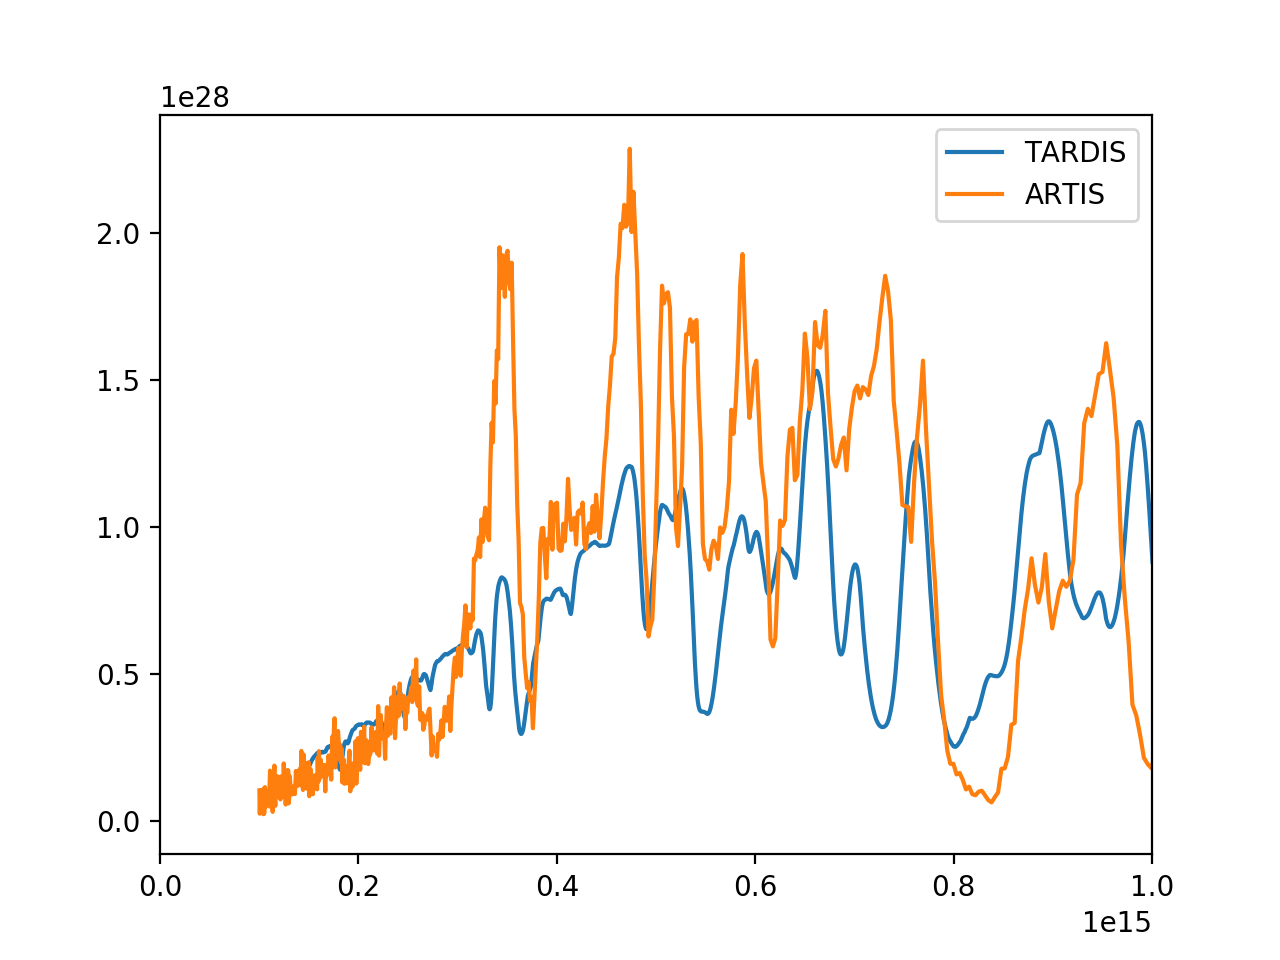

(0, 1000000000000000.0)

In [9]:
%pylab notebook

plot(sim.runner.spectrum_integrated.frequency, sim.runner.spectrum_integrated.luminosity_density_nu, label='TARDIS')
#plot(sim.runner.spectrum_integrated.wavelength, sim.runner.spectrum_integrated.luminosity_density_lambda)
plot(spec_artis_toy['nu'], spec_artis_toy.iloc[:,53] * np.pi * 4 * u.Mpc.to(u.cm)**2, label='ARTIS') 
legend()
xlim(0, 1e15)


In [28]:
spectrum = pd.DataFrame(data = sim.runner.spectrum_integrated.frequency.value, columns=['frequency'])
spectrum['luminosity'] = sim.runner.spectrum_integrated.luminosity_density_nu.value

create_df_download_link(spectrum, title='Download Spectrum', filename='spectrum.csv', type='csv')